In [ ]:
!pip install yfinance

In [ ]:
!pip install ta

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
import ta
warnings.filterwarnings('ignore')

In [4]:
from sklearn.metrics import r2_score

In [5]:
df = yf.download('EURUSD=X', start='2020-01-01', end='2021-12-31')

[*********************100%***********************]  1 of 1 completed


In [6]:
df.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,1.122083,1.122838,1.115947,1.122083,1.122083,0
2020-01-02,1.121894,1.122712,1.116682,1.122083,1.122083,0


In [7]:
#Add new features
df["ho"]=(((df.High-df.Open)/df.Open)*100)
df["ol"]=(((df.Open-df.Low)/df.Open)*100)
df["oc"]=(((df.Open-df.Close)/df.Open)*100)
df["hl"]=(((df.High-df.Low)/df.Low)*100)
df['rsi']=ta.momentum.rsi(df["Close"], window=14, fillna=False)
df['roc']=ta.momentum.roc(df['Close'], window = 14, fillna = False)
df['macd']=ta.trend.macd(df['Close'], window_slow=26, window_fast=12, fillna=False)
df['ema']=ta.trend.ema_indicator(df['Close'], window = 14, fillna = False)
df['sma']=ta.trend.sma_indicator(df['Close'], window = 14, fillna = False)
df['ma']=ta.momentum.kama(df["Close"], window =10, pow1=2, pow2=30, fillna=False)

In [8]:
df = df.dropna()

In [9]:
df.shape

(498, 16)

In [ ]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ho', 'ol', 'oc',
       'hl', 'rsi', 'roc', 'macd', 'ema', 'sma', 'ma'],
      dtype='object')

In [10]:
ytrain=[]
train2 = np.array(df)
for i in range(60,len(train2)):
  ytrain.append(train2[i,4]) #Adj Close is at index 4

In [11]:
#Scaling the values between 0 to 1
from sklearn.preprocessing import MinMaxScaler
ss= MinMaxScaler(feature_range=(0,1))
train = ss.fit_transform(np.array(df))

In [12]:
# Feature selection
xtrain=[]

for i in range(60,len(train)):
    #xtrain.append([train[i-60:i,0],train[i-60:i,1]])
    xtrain.append(train[i-60:i,:])
    #ytrain.append(train[i,0])

xtrain, ytrain = np.array(xtrain), np.array(ytrain)

In [13]:
xtrain.shape

(438, 60, 16)

In [14]:
#Reshaping the train data to make it as input for LTSM layer input_shape(batchzise,timesteps,input_dim)
xtrain= np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[2],xtrain.shape[1]))

In [15]:
xtrain.shape #Before : (463, 60, 1)

(438, 16, 60)

### Build an GRU Model

In [18]:
from keras.models import Sequential
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

In [ ]:
#initialisizng the model 
regression= Sequential()

regression.add(GRU(units=280,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],xtrain.shape[2])))
regression.add(Dropout(0.1))

regression.add(GRU(units=280,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.1))

regression.add(GRU(units=280,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.1))

regression.add(GRU(units=280,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.1))

regression.add(LSTM(units=280,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],xtrain.shape[2])))
regression.add(Dropout(0.1))

regression.add(LSTM(units=280,kernel_initializer='glorot_uniform'))
regression.add(Dropout(0.1))

regression.add(Dense(units=1))

regression.compile(optimizer='adam',loss='mean_squared_error')

#fitting the network
regression.fit(xtrain,ytrain,batch_size=30,epochs=100)

In [ ]:
#regression.save('model.h5')

In [23]:
regression.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 16, 280)           287280    
                                                                 
 dropout_13 (Dropout)        (None, 16, 280)           0         
                                                                 
 gru_13 (GRU)                (None, 16, 280)           472080    
                                                                 
 dropout_14 (Dropout)        (None, 16, 280)           0         
                                                                 
 gru_14 (GRU)                (None, 16, 280)           472080    
                                                                 
 dropout_15 (Dropout)        (None, 16, 280)           0         
                                                                 
 gru_15 (GRU)                (None, 16, 280)          

In [25]:
test_df = yf.download('EURUSD=X', start='2022-01-01', end='2022-06-30')

[*********************100%***********************]  1 of 1 completed


In [26]:
test_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,1.137385,1.137592,1.128541,1.137346,1.137346,0
2022-01-04,1.130199,1.132300,1.127345,1.130224,1.130224,0
2022-01-05,1.128541,1.134559,1.127764,1.128363,1.128363,0
2022-01-06,1.131222,1.133067,1.128554,1.131350,1.131350,0
2022-01-07,1.129586,1.135976,1.129050,1.129688,1.129688,0


In [27]:
#Add new features
test_df["ho"]=(((test_df.High-test_df.Open)/test_df.Open)*100)
test_df["ol"]=(((test_df.Open-test_df.Low)/test_df.Open)*100)
test_df["oc"]=(((test_df.Open-test_df.Close)/test_df.Open)*100)
test_df["hl"]=(((test_df.High-test_df.Low)/test_df.Low)*100)
test_df['rsi']=ta.momentum.rsi(test_df["Close"], window=14, fillna=False)
test_df['roc']=ta.momentum.roc(test_df['Close'], window = 14, fillna = False)
test_df['macd']=ta.trend.macd(test_df['Close'], window_slow=26, window_fast=12, fillna=False)
test_df['ema']=ta.trend.ema_indicator(test_df['Close'], window = 14, fillna = False)
test_df['sma']=ta.trend.sma_indicator(test_df['Close'], window = 14, fillna = False)
test_df['ma']=ta.momentum.kama(test_df["Close"], window =10, pow1=2, pow2=30, fillna=False)

In [28]:
test_df.shape

(129, 16)

In [29]:
test = test_df.copy()

In [30]:
test = test.dropna()


In [31]:
test.head()

,Open,High,Low,Close,Adj Close,Volume,ho,ol,oc,hl,rsi,roc,macd,ema,sma,ma
Date,,,,,,,,,,,,,,,,
2022-02-07,1.145462,1.146000,1.141670,1.145515,1.145515,0,0.046978,0.331081,-0.004579,0.379314,62.587029,0.390623,-0.000391,1.132311,1.129960,1.129164
2022-02-08,1.144086,1.145082,1.139705,1.144296,1.144296,0,0.087025,0.382941,-0.018307,0.471773,61.100646,1.000116,0.000583,1.133909,1.130769,1.129821
2022-02-09,1.142113,1.144700,1.140329,1.142126,1.142126,0,0.226538,0.156220,-0.001148,0.383356,58.440609,0.686415,0.001167,1.135004,1.131325,1.130339
2022-02-10,1.142126,1.149425,1.138084,1.142152,1.142152,0,0.639077,0.353946,-0.002275,0.996550,58.463936,0.952547,0.001613,1.135957,1.132095,1.131466
2022-02-11,1.141175,1.141901,1.137126,1.141553,1.141553,0,0.063607,0.354784,-0.033114,0.419881,57.659743,0.652970,0.001897,1.136703,1.132624,1.134286


In [32]:
test.shape

(104, 16)

In [33]:
total= pd.concat([df,test],axis=0) # Concating train and test and then will take last 60 train point


In [34]:
total.shape

(602, 16)

In [35]:
test_input = total[len(total)-len(test)-60:].values
#test_input= test_input.reshape(-1,1) # reshaping it to get it transformed
test_input= ss.transform(test_input)

In [36]:
xtest= []
for i in range(60,80):
    xtest.append(test_input[i-60:i,:]) #creating input for lstm prediction

In [37]:
xtest= np.array(xtest)

In [38]:
xtest.shape

(20, 60, 16)

In [39]:
xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[2],xtest.shape[1]))

In [40]:
#xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
predicted_value= regression.predict(xtest)

In [41]:
#predicted_value_inverted = ss.inverse_transform(predicted_value)

In [42]:
test_actual = np.array(test[0:20]['Adj Close'])

In [43]:
test_actual.shape

(20,)

In [44]:
predicted_value.shape

(20, 1)

In [45]:
r2_score(test_actual, predicted_value)

-15.967847181564526

As we see R-Squared score increased from -22.24741605656513 to -0.31 although it is not still a reliable model, so we will try to model as a classification problem.

### Plot the Data

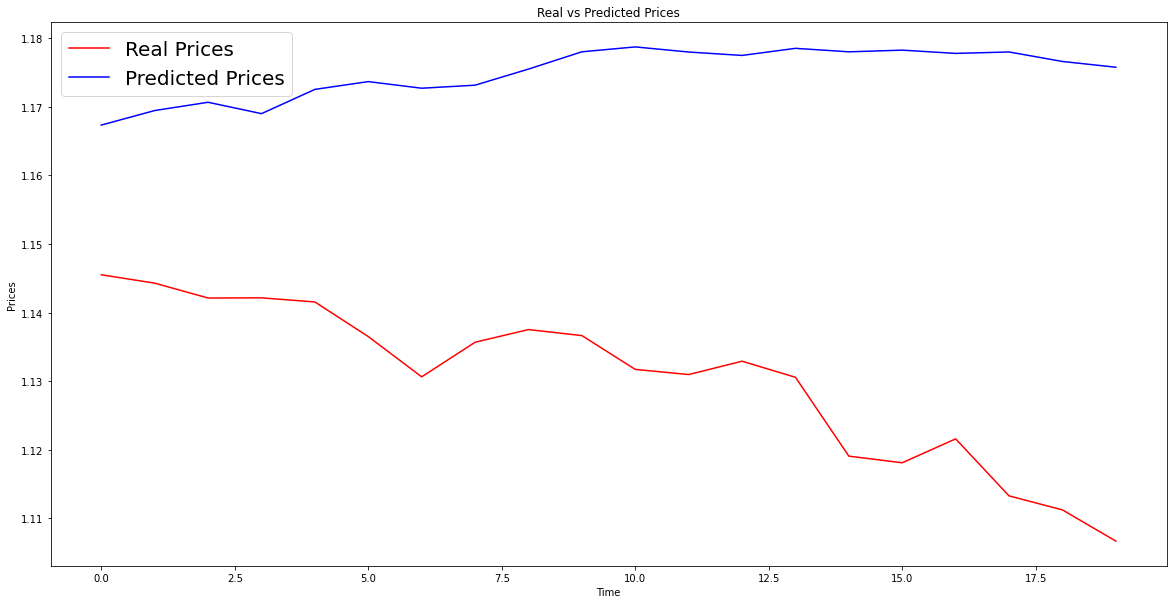

In [46]:
plt.figure(figsize=(20,10))
plt.plot(test_actual,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)